# Getting Started with AuctionGym
## My Experiments Run

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from main import parse_config, instantiate_agents, instantiate_auction, simulation_run
from tqdm.notebook import tqdm

In [2]:
import sys
modulenames = set(sys.modules) & set(globals())
allmodules = [sys.modules[name] for name in modulenames]
for module in allmodules:
    print(module.__name__)

tqdm
sys


In [3]:
config_file = '../config-mine/FP_Epsilon-average-out-results-test.json'

graph_title = config_file

In [4]:
# Parse configuration file
rng, config, agent_configs, agents2items, agents2item_values,\
num_runs, max_slots, embedding_size, embedding_var,\
obs_embedding_size = parse_config(config_file)

print('--- My Agents ---')

my_agents_names = []

i=0
for agent in config['agents']:
    for copies in range(agent['num_copies']):
        i+=1
        # my_agents_names.append(f'{i}.{agent["bidder"]["type"]} ({agent["name"]})')
        my_agents_names.append(f'{i}. {agent["name"]}')
        # print(f'{i}) {agent["bidder"]["type"]}')
print(my_agents_names)

print()
print('--- Runs Number ---')
print(f"making {config['num_runs']} runs.\nFor each, {config['num_iter']} iterations, each for {config['rounds_per_iter']} episodes.")
print(f"\t\t -> total: {config['num_runs']*config['num_iter']*config['rounds_per_iter']}")

--- My Agents ---
['1. EpsilonGreedy Bidder', '2. DM (policy)', '3. Shaded Bidder']

--- Runs Number ---
making 4 runs.
For each, 100 iterations, each for 10 episodes.
		 -> total: 4000


In [5]:
def run_repeated_auctions():
    # Placeholders for output
    auction_revenue = []
    social_welfare = []
    cumulative_surplus = []
    
    # Instantiate Agent and Auction objects
    agents = instantiate_agents(rng, agent_configs, agents2item_values, agents2items)
    
    agents_surplus = [[] for _ in range(len(agents))]

    # Instantiate Auction object
    auction, num_iter, rounds_per_iter, output_dir =\
        instantiate_auction(rng,
                            config,
                            agents2items,
                            agents2item_values,
                            agents,
                            max_slots,
                            embedding_size,
                            embedding_var,
                            obs_embedding_size)

    # Run repeated auctions
    # This logic is encoded in the `simulation_run()` method in main.py
    for i in tqdm(range(num_iter)):
        print(f'Iteration {i+1} of {num_iter}')

        # Simulate impression opportunities
        for _ in range(rounds_per_iter):
            auction.simulate_opportunity()

        # Log 'Gross utility' or welfare
        social_welfare.append(sum([agent.gross_utility for agent in auction.agents]))

        # Log 'Net utility' or surplus
        cumulative_surplus.append(sum([agent.net_utility for agent in auction.agents]))
        for agent_id, agent in enumerate(auction.agents):
            agents_surplus[agent_id].append(agent.net_utility)
        
        last_surplus = [surplus[-1] for surplus in agents_surplus]
        print(f"\teach agent's surplus: {last_surplus}")
        print(f"\tsums to {np.array(last_surplus).sum()}")
        # print(f"\tshould be equal to {cumulative_surplus[-1]}")
        # print(f"\t\t{(np.array(last_surplus).sum() == cumulative_surplus[-1])}")
        
        # Update agents (does nothing in this example, as we have truthful oracles)
        # Clear running metrics
        for agent_id, agent in enumerate(auction.agents):
            if(len(agent.logs)>0):
                print(f'\t agent update: {my_agents_names[agent_id]}')
                agent.update(iteration=i)
                agent.clear_utility()
                agent.clear_logs()

        # Log revenue
        auction_revenue.append(auction.revenue)
        auction.clear_revenue()
        
    # Rescale metrics per auction round
    auction_revenue = np.array(auction_revenue) / rounds_per_iter
    social_welfare = np.array(social_welfare) / rounds_per_iter
    cumulative_surplus = np.array(cumulative_surplus) / rounds_per_iter
    
    return auction_revenue, social_welfare, cumulative_surplus, agents_surplus

In [6]:
num_participants_2_metrics = run_repeated_auctions()
# print(num_participants_2_metrics)

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 1 of 100
	each agent's surplus: [-1.4506484867863714, -0.5392156249882164, -0.952713598514347]
	sums to -2.942577710288935
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 206.23it/s]


AUC predicting P(win):				 0.28571428571428575


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 334.67it/s]


	 agent update: 3. Shaded Bidder
Iteration 2 of 100
	each agent's surplus: [-3.3918124222547856, 0.0, 1.5425791665733075]
	sums to -1.8492332556814781
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)
! Fallback for DM (policy) 2
	 agent update: 3. Shaded Bidder
Iteration 3 of 100
	each agent's surplus: [0.0, -2.1740879805609197, -0.6608859232090517]
	sums to -2.8349739037699715
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1170.44it/s]


AUC predicting P(win):				 0.0


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 364.13it/s]


	 agent update: 3. Shaded Bidder
Iteration 4 of 100
	each agent's surplus: [0.20514660111912542, -0.6425689355400601, 0.2015028124177583]
	sums to -0.2359195220031764
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1001.72it/s]


AUC predicting P(win):				 0.6666666666666667


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 347.90it/s]


Epoch 00122: reducing learning rate of group 0 to 2.0000e-04.
	 agent update: 3. Shaded Bidder
Iteration 5 of 100
	each agent's surplus: [-0.9552849008530373, 1.8275893567815054, -0.26609985882649734]
	sums to 0.6062045971019707
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1328.66it/s]


AUC predicting P(win):				 0.7619047619047619


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 359.68it/s]


	 agent update: 3. Shaded Bidder
Iteration 6 of 100
	each agent's surplus: [0.0, 0.8207125041434417, 2.2613275525479226]
	sums to 3.082040056691364
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1287.82it/s]


AUC predicting P(win):				 0.7777777777777778


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 352.54it/s]


	 agent update: 3. Shaded Bidder
Iteration 7 of 100
	each agent's surplus: [-0.15, 0.0, -2.617948569746829]
	sums to -2.767948569746829
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)
! Fallback for DM (policy) 2
	 agent update: 3. Shaded Bidder
Iteration 8 of 100
	each agent's surplus: [0.0, -0.24701830476646008, 3.4712807049611905]
	sums to 3.22426240019473
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1203.19it/s]


AUC predicting P(win):				 0.5833333333333334


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 340.69it/s]


	 agent update: 3. Shaded Bidder
Iteration 9 of 100
	each agent's surplus: [0.0, 0.0, -0.386549626033041]
	sums to -0.386549626033041
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)
! Fallback for DM (policy) 2
	 agent update: 3. Shaded Bidder
Iteration 10 of 100
	each agent's surplus: [0.0, -2.0872834164433502, 0.1689107592562451]
	sums to -1.9183726571871051
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1022.47it/s]


AUC predicting P(win):				 0.4285714285714286


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 272.24it/s]


Epoch 00109: reducing learning rate of group 0 to 2.0000e-04.
	 agent update: 3. Shaded Bidder
Iteration 11 of 100
	each agent's surplus: [0.0, 0.8027086770119642, 0.16259088607205174]
	sums to 0.965299563084016
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1171.62it/s]


AUC predicting P(win):				 0.8888888888888888


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 329.08it/s]


	 agent update: 3. Shaded Bidder
Iteration 12 of 100
	each agent's surplus: [0.0, 0.0, 2.0832059055928034]
	sums to 2.0832059055928034
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)
! Fallback for DM (policy) 2
	 agent update: 3. Shaded Bidder
Iteration 13 of 100
	each agent's surplus: [-1.4, -0.9521858135813954, -1.5876559947943722]
	sums to -3.9398418083757676
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1315.54it/s]


AUC predicting P(win):				 0.32


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 366.02it/s]


	 agent update: 3. Shaded Bidder
Iteration 14 of 100
	each agent's surplus: [0.0, 0.0, 3.1036130110413724]
	sums to 3.1036130110413724
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)
! Fallback for DM (policy) 2
	 agent update: 3. Shaded Bidder
Iteration 15 of 100
	each agent's surplus: [0.0, 1.391764252205964, -0.4060788853431835]
	sums to 0.9856853668627804
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1313.14it/s]


AUC predicting P(win):				 0.47619047619047616


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 361.70it/s]


	 agent update: 3. Shaded Bidder
Iteration 16 of 100
	each agent's surplus: [0.0, 0.0, -0.558654569085951]
	sums to -0.558654569085951
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)
! Fallback for DM (policy) 2
	 agent update: 3. Shaded Bidder
Iteration 17 of 100
	each agent's surplus: [0.0, 1.0490106902880174, -0.2801732431337595]
	sums to 0.7688374471542578
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1301.75it/s]


AUC predicting P(win):				 0.5714285714285714


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 256.98it/s]


	 agent update: 3. Shaded Bidder
Iteration 18 of 100
	each agent's surplus: [0.0, 0.0, 2.569111914386535]
	sums to 2.569111914386535
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)
! Fallback for DM (policy) 2
	 agent update: 3. Shaded Bidder
Iteration 19 of 100
	each agent's surplus: [0.0, -0.6039707567029241, 2.336559521509775]
	sums to 1.732588764806851
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1288.73it/s]


AUC predicting P(win):				 0.33333333333333337


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 212.04it/s]


	 agent update: 3. Shaded Bidder
Iteration 20 of 100
	each agent's surplus: [0.0, -0.33814717654708826, -0.17951703366039184]
	sums to -0.5176642102074801
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 591.31it/s]


AUC predicting P(win):				 0.375


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 289.30it/s]


	 agent update: 3. Shaded Bidder
Iteration 21 of 100
	each agent's surplus: [0.0, -0.08325443952829398, 0.9173268600330866]
	sums to 0.8340724205047927
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 925.75it/s]


AUC predicting P(win):				 0.4444444444444444


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 340.49it/s]


	 agent update: 3. Shaded Bidder
Iteration 22 of 100
	each agent's surplus: [0.0, 0.43339071502331844, -1.1333357411167788]
	sums to -0.6999450260934603
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 784.83it/s]


AUC predicting P(win):				 0.3125


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 289.22it/s]


	 agent update: 3. Shaded Bidder
Iteration 23 of 100
	each agent's surplus: [0.0, 0.7985833059840958, -2.2007273692959544]
	sums to -1.4021440633118587
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 945.94it/s]


AUC predicting P(win):				 0.33333333333333337


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 340.97it/s]


	 agent update: 3. Shaded Bidder
Iteration 24 of 100
	each agent's surplus: [0.0, 0.5646313352665542, 0.04639225549772852]
	sums to 0.6110235907642827
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 902.55it/s]


AUC predicting P(win):				 0.375


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 338.97it/s]


	 agent update: 3. Shaded Bidder
Iteration 25 of 100
	each agent's surplus: [0.0, 0.3593678878737421, 2.837944377346562]
	sums to 3.1973122652203037
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 638.17it/s]


AUC predicting P(win):				 0.6875


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 329.60it/s]


	 agent update: 3. Shaded Bidder
Iteration 26 of 100
	each agent's surplus: [0.5051466011191255, 0.9461577083170252, 0.576307860029092]
	sums to 2.0276121694652427
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 921.38it/s]


AUC predicting P(win):				 0.6666666666666667


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 334.72it/s]


	 agent update: 3. Shaded Bidder
Iteration 27 of 100
	each agent's surplus: [-1.001526164898456, 0.0, 1.3831316999192746]
	sums to 0.38160553502081873
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)
! Fallback for DM (policy) 2
	 agent update: 3. Shaded Bidder
Iteration 28 of 100
	each agent's surplus: [-0.8, -1.0807024217549597, -1.431606083569233]
	sums to -3.312308505324193
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 967.93it/s]


AUC predicting P(win):				 0.31999999999999995


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 326.17it/s]


	 agent update: 3. Shaded Bidder
Iteration 29 of 100
	each agent's surplus: [0.0, 0.8617485533870949, 1.6738916535373256]
	sums to 2.5356402069244206
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 591.25it/s]


AUC predicting P(win):				 0.6190476190476191


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 343.28it/s]


	 agent update: 3. Shaded Bidder
Iteration 30 of 100
	each agent's surplus: [0.0, 0.7689714649173998, -0.8039997538781896]
	sums to -0.0350282889607898
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 922.50it/s]


AUC predicting P(win):				 0.43999999999999995


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 327.16it/s]


	 agent update: 3. Shaded Bidder
Iteration 31 of 100
	each agent's surplus: [0.0, 2.1423314171189625, 3.0666618432381707]
	sums to 5.208993260357133
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 953.98it/s]


AUC predicting P(win):				 0.1875


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 291.11it/s]


	 agent update: 3. Shaded Bidder
Iteration 32 of 100
	each agent's surplus: [0.0, 0.550217291004539, 0.7835194975582491]
	sums to 1.333736788562788
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 960.79it/s]


AUC predicting P(win):				 0.375


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 337.44it/s]


	 agent update: 3. Shaded Bidder
Iteration 33 of 100
	each agent's surplus: [-0.8, 0.7366440174741596, 0.5238278227462747]
	sums to 0.4604718402204343
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 900.08it/s]


AUC predicting P(win):				 0.5555555555555556


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 343.81it/s]


	 agent update: 3. Shaded Bidder
Iteration 34 of 100
	each agent's surplus: [0.0, 0.5506059617304313, 1.8210618729827162]
	sums to 2.3716678347131475
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 749.93it/s]


AUC predicting P(win):				 0.25


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 291.56it/s]


	 agent update: 3. Shaded Bidder
Iteration 35 of 100
	each agent's surplus: [0.7493515132136286, 0.6493512515106714, -0.37639000922835564]
	sums to 1.0223127554959444
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 857.80it/s]


AUC predicting P(win):				 0.5


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 284.65it/s]


	 agent update: 3. Shaded Bidder
Iteration 36 of 100
	each agent's surplus: [0.0, -0.023932637181226513, -1.0754669388111928]
	sums to -1.0993995759924193
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 750.08it/s]


AUC predicting P(win):				 0.6799999999999999


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 332.63it/s]


	 agent update: 3. Shaded Bidder
Iteration 37 of 100
	each agent's surplus: [0.0, 3.3234373665549963, 0.5948675865988196]
	sums to 3.918304953153816
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 644.80it/s]


AUC predicting P(win):				 0.9583333333333334


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 334.84it/s]


	 agent update: 3. Shaded Bidder
Iteration 38 of 100
	each agent's surplus: [-1.4, 0.0, 1.3683994039603098]
	sums to -0.03160059603969012
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)
! Fallback for DM (policy) 2
	 agent update: 3. Shaded Bidder
Iteration 39 of 100
	each agent's surplus: [-0.8, 0.9543062950169491, -0.17776124214363392]
	sums to -0.02345494712668489
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 777.43it/s]


AUC predicting P(win):				 0.7142857142857143


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 286.97it/s]


	 agent update: 3. Shaded Bidder
Iteration 40 of 100
	each agent's surplus: [0.0, 0.45374227778182313, 1.4070623107048204]
	sums to 1.8608045884866435
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 839.08it/s]


AUC predicting P(win):				 0.5833333333333334


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 341.61it/s]


	 agent update: 3. Shaded Bidder
Iteration 41 of 100
	each agent's surplus: [-1.4, -0.15786427579729267, 1.0990768927875547]
	sums to -0.45878738300973776
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 572.80it/s]


AUC predicting P(win):				 0.33333333333333337


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 230.77it/s]


	 agent update: 3. Shaded Bidder
Iteration 42 of 100
	each agent's surplus: [0.0, 1.9073470968237485, 1.7334201948709098]
	sums to 3.640767291694658
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 811.76it/s]


AUC predicting P(win):				 0.5


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 221.74it/s]


	 agent update: 3. Shaded Bidder
Iteration 43 of 100
	each agent's surplus: [0.0, 0.7811812360499346, 1.1423830878330763]
	sums to 1.923564323883011
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1120.65it/s]


AUC predicting P(win):				 0.5833333333333334


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 377.72it/s]


	 agent update: 3. Shaded Bidder
Iteration 44 of 100
	each agent's surplus: [0.0, 2.011069102384157, -0.4899447256959676]
	sums to 1.5211243766881895
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1343.59it/s]


AUC predicting P(win):				 0.6666666666666667


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 383.76it/s]


	 agent update: 3. Shaded Bidder
Iteration 45 of 100
	each agent's surplus: [0.0, 0.6396593473670469, 0.01941198849090231]
	sums to 0.6590713358579492
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 661.30it/s]


AUC predicting P(win):				 0.75


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 371.29it/s]


	 agent update: 3. Shaded Bidder
Iteration 46 of 100
	each agent's surplus: [0.0, 2.258232827952744, 1.2435460372012708]
	sums to 3.501778865154015
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1371.28it/s]


AUC predicting P(win):				 0.7142857142857142


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 335.50it/s]


	 agent update: 3. Shaded Bidder
Iteration 47 of 100
	each agent's surplus: [0.0, 3.1394857917053267, 1.076806985773736]
	sums to 4.216292777479063
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1355.70it/s]


AUC predicting P(win):				 0.6666666666666666


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 391.42it/s]


	 agent update: 3. Shaded Bidder
Iteration 48 of 100
	each agent's surplus: [0.0, 1.4409065360254671, -0.15362930642008307]
	sums to 1.287277229605384
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 758.95it/s]


AUC predicting P(win):				 1.0


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 378.27it/s]


	 agent update: 3. Shaded Bidder
Iteration 49 of 100
	each agent's surplus: [0.0, 1.0440725842607863, -3.3252081128676196]
	sums to -2.2811355286068333
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1197.14it/s]


AUC predicting P(win):				 0.6666666666666667


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 335.63it/s]


	 agent update: 3. Shaded Bidder
Iteration 50 of 100
	each agent's surplus: [0.0, -0.678339099183785, -0.36644131906224087]
	sums to -1.0447804182460259
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1432.03it/s]


AUC predicting P(win):				 0.4761904761904762


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 363.29it/s]


	 agent update: 3. Shaded Bidder
Iteration 51 of 100
	each agent's surplus: [0.0, 0.19597826706878768, -0.007376528814059924]
	sums to 0.18860173825472776
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 806.78it/s]


AUC predicting P(win):				 0.375


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 360.25it/s]


	 agent update: 3. Shaded Bidder
Iteration 52 of 100
	each agent's surplus: [0.0, 1.785645513532848, 0.009214269377564754]
	sums to 1.7948597829104127
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1370.86it/s]


AUC predicting P(win):				 0.9523809523809524


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 340.99it/s]


	 agent update: 3. Shaded Bidder
Iteration 53 of 100
	each agent's surplus: [0.0, 1.0690794571689681, -0.6034412955798368]
	sums to 0.4656381615891313
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1327.79it/s]


AUC predicting P(win):				 0.43999999999999995


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 323.43it/s]


	 agent update: 3. Shaded Bidder
Iteration 54 of 100
	each agent's surplus: [0.0, 2.3795928978438186, -1.9192536236739408]
	sums to 0.46033927416987774
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 535.68it/s]


AUC predicting P(win):				 0.6666666666666667


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 370.20it/s]


	 agent update: 3. Shaded Bidder
Iteration 55 of 100
	each agent's surplus: [0.20514660111912542, 1.4390656333863094, -1.1772642812553797]
	sums to 0.4669479532500551
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1343.08it/s]


AUC predicting P(win):				 0.625


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 342.92it/s]


Epoch 00104: reducing learning rate of group 0 to 2.0000e-04.
	 agent update: 3. Shaded Bidder
Iteration 56 of 100
	each agent's surplus: [0.0, -0.060820889145007495, 1.6371907512189412]
	sums to 1.5763698620739337
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1341.97it/s]


AUC predicting P(win):				 0.42857142857142855


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 323.57it/s]


	 agent update: 3. Shaded Bidder
Iteration 57 of 100
	each agent's surplus: [0.0, -0.3450539125586663, -1.1451185550901661]
	sums to -1.4901724676488324
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1216.24it/s]


AUC predicting P(win):				 0.5555555555555556


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 377.52it/s]


	 agent update: 3. Shaded Bidder
Iteration 58 of 100
	each agent's surplus: [0.0, 1.1755985736886692, 2.184589006539909]
	sums to 3.360187580228578
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1371.23it/s]


AUC predicting P(win):				 0.7142857142857143


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 407.80it/s]


	 agent update: 3. Shaded Bidder
Iteration 59 of 100
	each agent's surplus: [-1.4, -1.2254231693857374, -1.0673886872666203]
	sums to -3.6928118566523573
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1342.17it/s]


AUC predicting P(win):				 0.4


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 268.99it/s]


	 agent update: 3. Shaded Bidder
Iteration 60 of 100
	each agent's surplus: [0.0, 0.5670253295802007, -1.170048317415977]
	sums to -0.6030229878357763
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1063.97it/s]


AUC predicting P(win):				 0.8571428571428572


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 296.24it/s]


	 agent update: 3. Shaded Bidder
Iteration 61 of 100
	each agent's surplus: [0.0, 0.7264192089796232, 0.49398730222368203]
	sums to 1.2204065112033051
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 994.54it/s] 


AUC predicting P(win):				 0.75


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 302.56it/s]


	 agent update: 3. Shaded Bidder
Iteration 62 of 100
	each agent's surplus: [0.0, -0.17185917583412053, 3.8193244090514993]
	sums to 3.6474652332173787
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1182.15it/s]


AUC predicting P(win):				 0.4444444444444444


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 303.63it/s]


	 agent update: 3. Shaded Bidder
Iteration 63 of 100
	each agent's surplus: [0.0, 0.0, 3.25452667544244]
	sums to 3.25452667544244
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)
! Fallback for DM (policy) 2
	 agent update: 3. Shaded Bidder
Iteration 64 of 100
	each agent's surplus: [0.0, 0.9528744564814937, 2.0955567156054022]
	sums to 3.0484311720868957
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 975.81it/s]


AUC predicting P(win):				 0.8333333333333334


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 366.33it/s]


	 agent update: 3. Shaded Bidder
Iteration 65 of 100
	each agent's surplus: [0.0, -0.7240266817321797, 0.36245958459736793]
	sums to -0.3615670971348117
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1315.61it/s]


AUC predicting P(win):				 0.5


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 330.46it/s]


	 agent update: 3. Shaded Bidder
Iteration 66 of 100
	each agent's surplus: [0.0, 1.7886548477881954, 1.3196426910251724]
	sums to 3.1082975388133676
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1387.47it/s]


AUC predicting P(win):				 0.56


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 389.35it/s]


	 agent update: 3. Shaded Bidder
Iteration 67 of 100
	each agent's surplus: [0.0, -1.6415915402173662, 1.6556286351520828]
	sums to 0.01403709493471661
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1327.28it/s]


AUC predicting P(win):				 0.8333333333333334


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 357.53it/s]


	 agent update: 3. Shaded Bidder
Iteration 68 of 100
	each agent's surplus: [0.0, 3.4638971741463913, 1.6789220188793357]
	sums to 5.142819193025727
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1214.91it/s]


AUC predicting P(win):				 0.8333333333333334


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 306.73it/s]


	 agent update: 3. Shaded Bidder
Iteration 69 of 100
	each agent's surplus: [0.0, 0.0, 1.5762230420183954]
	sums to 1.5762230420183954
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)
! Fallback for DM (policy) 2
	 agent update: 3. Shaded Bidder
Iteration 70 of 100
	each agent's surplus: [0.0, -1.1221163687201403, 0.7842069526029467]
	sums to -0.3379094161171936
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1315.44it/s]


AUC predicting P(win):				 0.8095238095238095


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 398.41it/s]


	 agent update: 3. Shaded Bidder
Iteration 71 of 100
	each agent's surplus: [0.0, 0.055143202626922516, 3.1211418123589283]
	sums to 3.176285014985851
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1408.98it/s]


AUC predicting P(win):				 0.8


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 357.56it/s]


	 agent update: 3. Shaded Bidder
Iteration 72 of 100
	each agent's surplus: [0.0, 0.5433021023958913, -0.7479107823330945]
	sums to -0.20460867993720322
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 788.86it/s]


AUC predicting P(win):				 0.7916666666666666


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 384.54it/s]


	 agent update: 3. Shaded Bidder
Iteration 73 of 100
	each agent's surplus: [-0.15064848678637133, -0.2582819978819384, 2.6859244215573757]
	sums to 2.276993936889066
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1393.70it/s]


AUC predicting P(win):				 0.5625


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 379.87it/s]


	 agent update: 3. Shaded Bidder
Iteration 74 of 100
	each agent's surplus: [0.0, 0.45804232908674536, 0.6103518530391572]
	sums to 1.0683941821259024
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1073.43it/s]


AUC predicting P(win):				 0.7083333333333334


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 288.22it/s]


	 agent update: 3. Shaded Bidder
Iteration 75 of 100
	each agent's surplus: [0.0, 2.0587907266327177, 0.44649114482693353]
	sums to 2.505281871459651
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1082.52it/s]


AUC predicting P(win):				 0.8095238095238095


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 351.37it/s]


	 agent update: 3. Shaded Bidder
Iteration 76 of 100
	each agent's surplus: [0.0, -0.3274541451132411, -0.02608665863474602]
	sums to -0.35354080374798713
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1327.39it/s]


AUC predicting P(win):				 0.5416666666666666


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 339.30it/s]


	 agent update: 3. Shaded Bidder
Iteration 77 of 100
	each agent's surplus: [0.0, 0.3131544230675063, 0.5606020800374114]
	sums to 0.8737565031049177
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 724.68it/s]


AUC predicting P(win):				 0.6666666666666666


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 336.74it/s]


	 agent update: 3. Shaded Bidder
Iteration 78 of 100
	each agent's surplus: [0.0, -1.2607127682521377, -1.2423432316002379]
	sums to -2.503055999852376
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1288.99it/s]


AUC predicting P(win):				 0.5416666666666667


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 347.61it/s]


	 agent update: 3. Shaded Bidder
Iteration 79 of 100
	each agent's surplus: [0.0, 1.458984032833389, -0.4481577112646296]
	sums to 1.0108263215687594
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1120.26it/s]


AUC predicting P(win):				 0.38095238095238093


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 308.36it/s]


	 agent update: 3. Shaded Bidder
Iteration 80 of 100
	each agent's surplus: [0.0, 1.9643376522288754, -1.8001031918804764]
	sums to 0.16423446034839895
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1192.92it/s]


AUC predicting P(win):				 0.7083333333333334


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 321.43it/s]


	 agent update: 3. Shaded Bidder
Iteration 81 of 100
	each agent's surplus: [0.0, 0.6038072998001458, 0.9399022627904913]
	sums to 1.543709562590637
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1120.67it/s]


AUC predicting P(win):				 0.9523809523809524


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 323.61it/s]


	 agent update: 3. Shaded Bidder
Iteration 82 of 100
	each agent's surplus: [0.0, 0.29424554451635726, 0.5028825447143315]
	sums to 0.7971280892306887
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 712.90it/s]


AUC predicting P(win):				 0.875


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 361.20it/s]


	 agent update: 3. Shaded Bidder
Iteration 83 of 100
	each agent's surplus: [0.0, -1.0283862350235153, 0.3182644510406414]
	sums to -0.710121783982874
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1288.54it/s]


AUC predicting P(win):				 0.75


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 354.16it/s]


	 agent update: 3. Shaded Bidder
Iteration 84 of 100
	each agent's surplus: [0.0, 2.644670573345923, -0.011227602079315724]
	sums to 2.633442971266607
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1161.16it/s]


AUC predicting P(win):				 0.625


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 306.06it/s]


	 agent update: 3. Shaded Bidder
Iteration 85 of 100
	each agent's surplus: [-1.4, 1.8931443888848019, 1.1816513728817366]
	sums to 1.6747957617665385
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1096.60it/s]


AUC predicting P(win):				 0.5833333333333334


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 361.76it/s]


	 agent update: 3. Shaded Bidder
Iteration 86 of 100
	each agent's surplus: [0.0, 0.1775121385058787, 0.5924422487834026]
	sums to 0.7699543872892813
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1301.59it/s]


AUC predicting P(win):				 0.875


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 390.87it/s]


	 agent update: 3. Shaded Bidder
Iteration 87 of 100
	each agent's surplus: [0.0, 2.1899661408959332, 1.748264924156346]
	sums to 3.938231065052279
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1160.49it/s]


AUC predicting P(win):				 0.7083333333333334


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 294.19it/s]


	 agent update: 3. Shaded Bidder
Iteration 88 of 100
	each agent's surplus: [0.0, 0.061826309285132997, -0.052881671106765005]
	sums to 0.008944638178367992
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1341.59it/s]


AUC predicting P(win):				 0.5714285714285714


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 363.79it/s]


	 agent update: 3. Shaded Bidder
Iteration 89 of 100
	each agent's surplus: [0.0, 2.535304558166551, -0.7293273149292863]
	sums to 1.805977243237265
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1239.29it/s]


AUC predicting P(win):				 0.75


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 399.89it/s]


	 agent update: 3. Shaded Bidder
Iteration 90 of 100
	each agent's surplus: [0.0, 0.17495547845977122, 2.783275234326549]
	sums to 2.95823071278632
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 796.90it/s]


AUC predicting P(win):				 0.4


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 388.00it/s]


	 agent update: 3. Shaded Bidder
Iteration 91 of 100
	each agent's surplus: [0.0, 0.6238938284580555, 1.4318466559131906]
	sums to 2.0557404843712463
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1315.63it/s]


AUC predicting P(win):				 0.75


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 383.32it/s]


	 agent update: 3. Shaded Bidder
Iteration 92 of 100
	each agent's surplus: [0.0, 1.0344770891300965, 1.5218052265605566]
	sums to 2.556282315690653
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1130.62it/s]


AUC predicting P(win):				 0.43999999999999995


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 366.85it/s]


	 agent update: 3. Shaded Bidder
Iteration 93 of 100
	each agent's surplus: [0.0, 0.6694557753599721, 1.2976892695542361]
	sums to 1.9671450449142083
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1101.40it/s]


AUC predicting P(win):				 0.5833333333333334


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 391.02it/s]


	 agent update: 3. Shaded Bidder
Iteration 94 of 100
	each agent's surplus: [0.0, -0.7398053785980638, 2.6588515477785393]
	sums to 1.9190461691804754
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1006.17it/s]


AUC predicting P(win):				 0.6666666666666666


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 381.06it/s]


	 agent update: 3. Shaded Bidder
Iteration 95 of 100
	each agent's surplus: [0.0, 1.2597516772266957, -0.3525366266791975]
	sums to 0.9072150505474982
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1369.61it/s]


AUC predicting P(win):				 1.0


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 299.76it/s]


	 agent update: 3. Shaded Bidder
Iteration 96 of 100
	each agent's surplus: [0.0, 1.1123679418772077, 0.4671562510622782]
	sums to 1.5795241929394859
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1343.00it/s]


AUC predicting P(win):				 0.1111111111111111


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 404.36it/s]


	 agent update: 3. Shaded Bidder
Iteration 97 of 100
	each agent's surplus: [0.0, 0.3941630051914715, 1.3918874311646394]
	sums to 1.786050436356111
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1308.54it/s]


AUC predicting P(win):				 0.5


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 396.44it/s]


	 agent update: 3. Shaded Bidder
Iteration 98 of 100
	each agent's surplus: [0.0, 0.0, 2.107634154936668]
	sums to 2.107634154936668
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)
! Fallback for DM (policy) 2
	 agent update: 3. Shaded Bidder
Iteration 99 of 100
	each agent's surplus: [0.0, 0.719581746403652, 2.9434745920707877]
	sums to 3.6630563384744397
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 747.48it/s]


AUC predicting P(win):				 0.5416666666666667


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 383.40it/s]


	 agent update: 3. Shaded Bidder
Iteration 100 of 100
	each agent's surplus: [0.0, 0.3115835615847452, 0.24038097334665848]
	sums to 0.5519645349314037
	 agent update: 1. EpsilonGreedy Bidder
	 agent update: 2. DM (policy)


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 1342.61it/s]


AUC predicting P(win):				 0.875


DM (policy) 2: 100%|██████████| 128/128 [00:00<00:00, 400.54it/s]

	 agent update: 3. Shaded Bidder


In [8]:
r, w, s, a_s = num_participants_2_metrics
for i, agent in enumerate(a_s):
    print(f'\t{my_agents_names[i]} surplus: {np.array(agent).sum()}')


	1. EpsilonGreedy Bidder surplus: -14.835129145008015
	2. DM (policy) surplus: 53.789416592553536
	3. Shaded Bidder surplus: 59.70786098806404


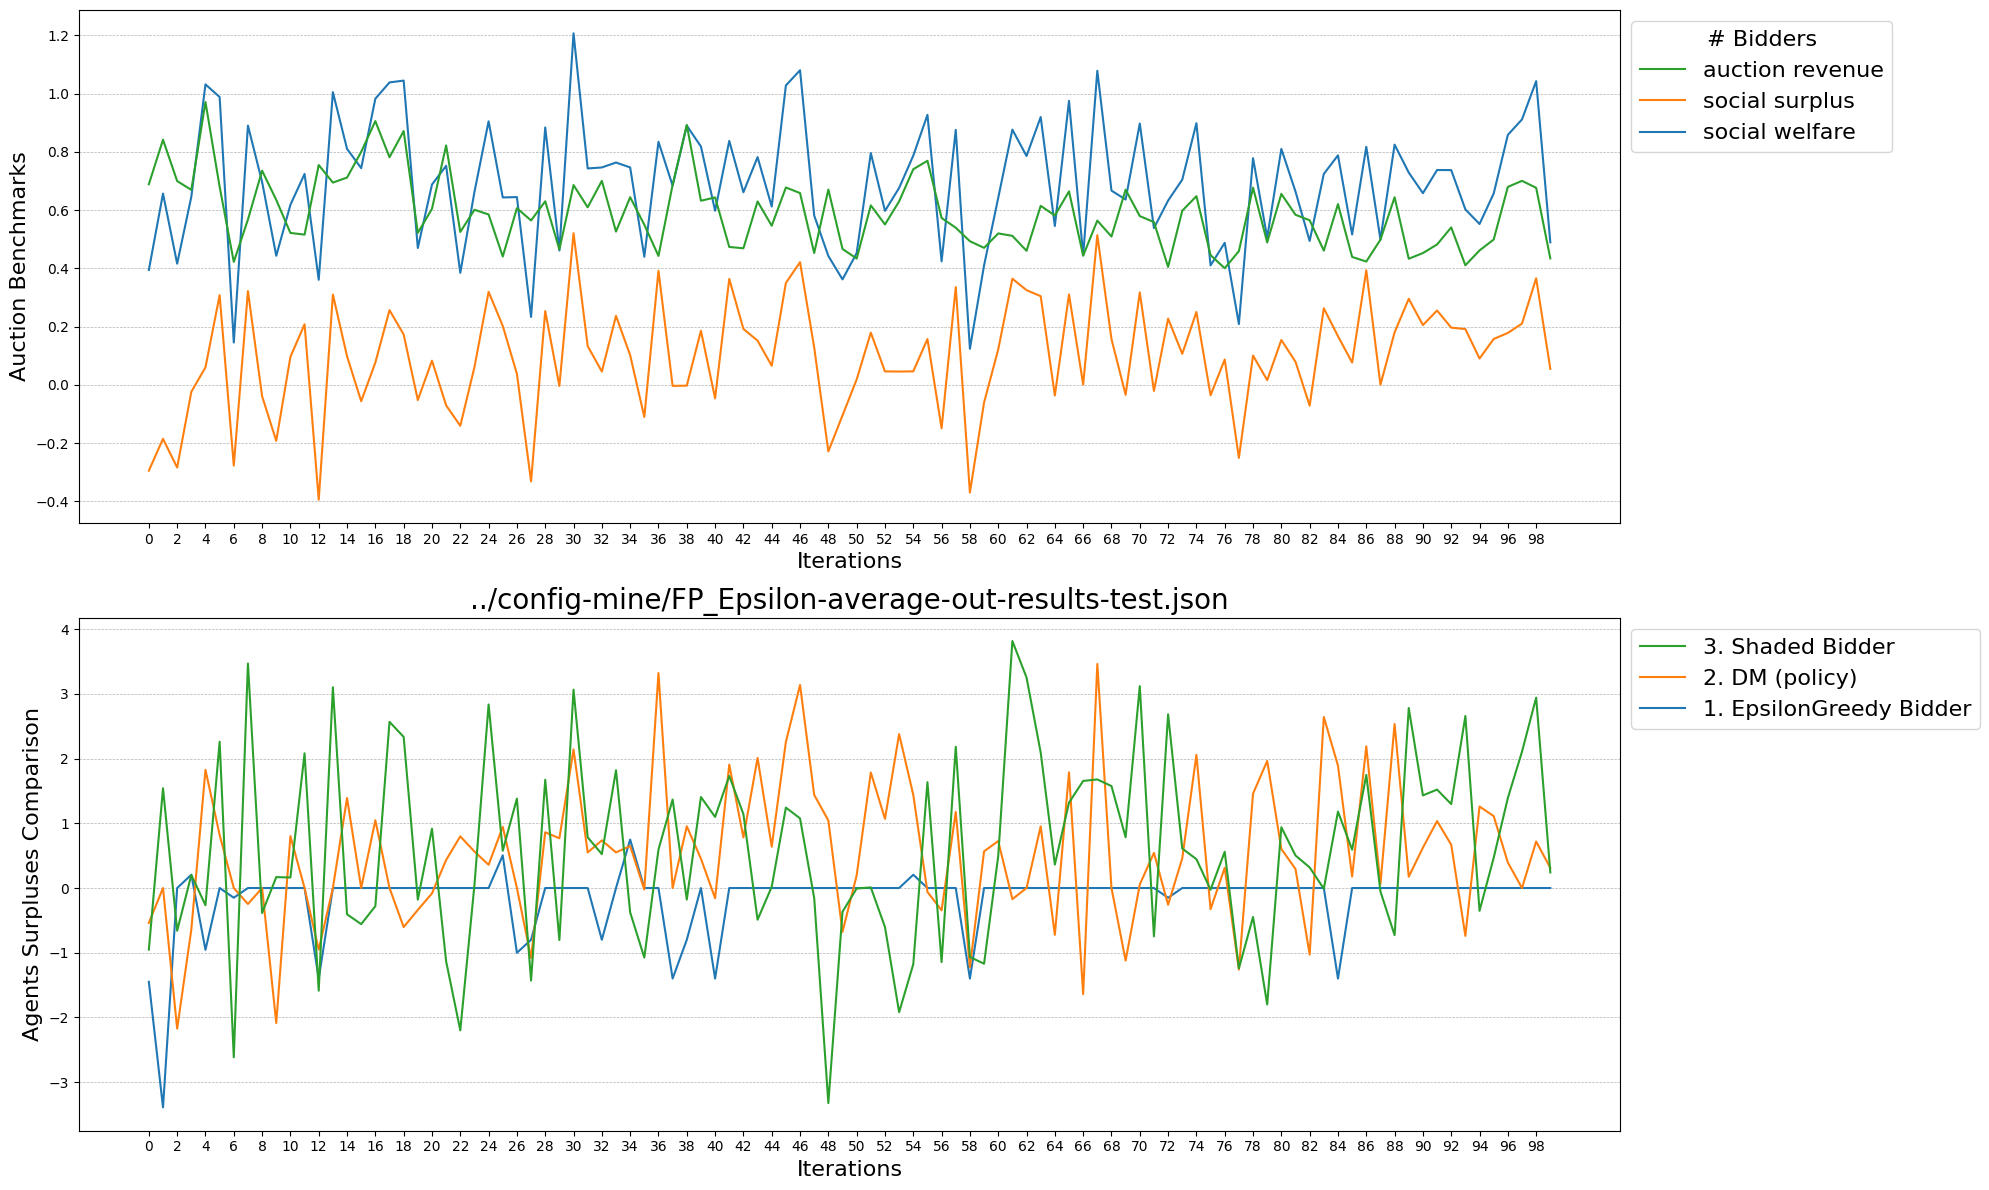

In [10]:
fontsize=16
fig, axes = plt.subplots(2,1, sharey='row', figsize=(20,12))

# for num_participants_per_round, (revenue, welfare, surplus) in num_participants_2_metrics.items():    
#     axes[0].plot(welfare, label=f'{num_participants_per_round}')
#     axes[1].plot(surplus, label=f'{num_participants_per_round}')
#     axes[2].plot(revenue, label=f'{num_participants_per_round}')

graph_auction_bench = axes[0]
graph_surpluses = axes[1]

revenue, welfare, agent, agents_surplus = num_participants_2_metrics   
graph_auction_bench.plot(welfare, label=f'social welfare')
graph_auction_bench.plot(agent, label=f'social surplus')
graph_auction_bench.plot(revenue, label=f'auction revenue')

for i, agent in enumerate(agents_surplus):
    graph_surpluses.plot(agent, label=my_agents_names[i])


graph_surpluses.set_title(graph_title, fontsize=fontsize+4)

for i in range(len(axes)):
    axes[i].set_xlabel('Iterations', fontsize=fontsize)
    axes[i].set_xticks(list(range(0,len(revenue),2)))
    axes[i].grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

    
graph_auction_bench.set_ylabel('Auction Benchmarks', fontsize=fontsize)
graph_surpluses.set_ylabel('Agents Surpluses Comparison', fontsize=fontsize)

handles, labels = graph_auction_bench.get_legend_handles_labels()
legend = graph_auction_bench.legend(reversed(handles),
                   reversed(labels),
                   loc='upper left',
                   bbox_to_anchor=(1.0, 1.0),
                   fontsize=fontsize)
legend.set_title('# Bidders', prop={'size': fontsize})

handles2, labels2 = graph_surpluses.get_legend_handles_labels()
legend2 = graph_surpluses.legend(reversed(handles2),
                         reversed(labels2),
                         loc='upper left',
                         bbox_to_anchor=(1.0, 1.0),
                         fontsize=fontsize)

fig.tight_layout()

plt.show()